# Problem: Classifying Sneakers versus Sandals
## Summarising the datasets

In [44]:
import pandas as pd

# Read the FMNIST training set and labels CSV file
train_labels = pd.read_csv('FMNIST_training_set_labels.csv', header=None, names=['label'])
train_set = pd.read_csv('FMNIST_training_set.csv', header=None)

# Read the FMNIST test set and labels CSV file
test_labels = pd.read_csv('FMNIST_test_set_labels.csv', header=None, names=['label'])
test_set = pd.read_csv('FMNIST_test_set.csv', header=None)

# Filter the set and labels to only include sneakers (7) and sandals (5)
ss_train_labels = train_labels[train_labels['label'].isin([5, 7])].copy()
ss_train_set = train_set[train_labels['label'].isin([5, 7])].copy()
ss_test_labels = test_labels[test_labels['label'].isin([5, 7])].copy()
ss_test_set = test_set[test_labels['label'].isin([5, 7])].copy()

# Replace the labels with 0 for sandals and 1 for sneakers
ss_train_labels['label'] = ss_train_labels['label'].replace({5: 1, 7: 0})
ss_test_labels['label'] = ss_test_labels['label'].replace({5: 1, 7: 0})

# Combined training data and testing data
ss_train = pd.concat([ss_train_labels, ss_train_set], axis=1)
ss_test = pd.concat([ss_test_labels, ss_test_set], axis=1)

# Get number of instances in the training set, test set, and total
num_train_instances = len(ss_train_set)
num_test_instances = len(ss_test_set)
num_total_instances = num_train_instances + num_test_instances
print('Number of training instances:', num_train_instances)
print('Number of test instances:', num_test_instances)
print('Total number of instances:', num_total_instances)

Number of training instances: 11988
Number of test instances: 2000
Total number of instances: 13988


The training set is balanced.


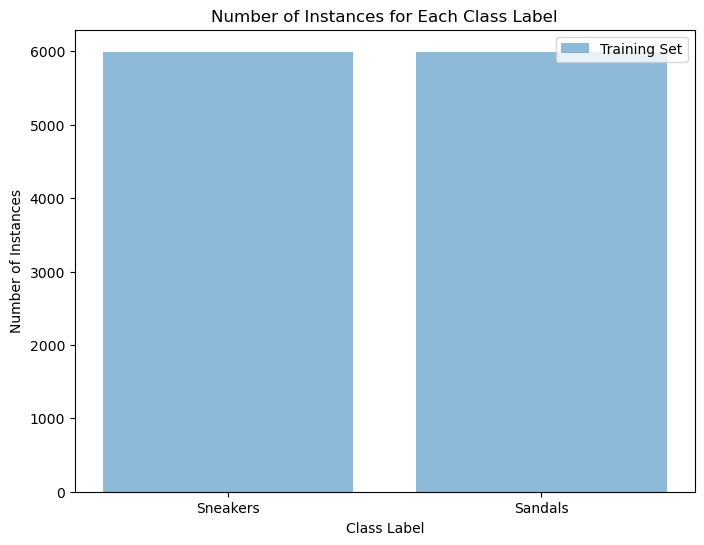

In [100]:
import matplotlib.pyplot as plt

# Get the counts of each class label in the training set and test set
train_label_counts = ss_train['label'].value_counts()
# test_label_counts = ss_test_labels['label'].value_counts()

# Check if the training set is imbalanced
if abs(train_label_counts[0] - train_label_counts[1]) > 0.5 * num_train_instances:
    print('The training set is imbalanced.')
else:
    print('The training set is balanced.')

# Plotting the bar plot
plt.figure(figsize=(8, 6))
plt.bar(train_label_counts.index, train_label_counts.values, alpha=0.5, label='Training Set')
# plt.bar(test_label_counts.index, test_label_counts.values, alpha=0.5, label='Test Set')
plt.xticks([0, 1], ['Sneakers', 'Sandals'])
plt.xlabel('Class Label')
plt.ylabel('Number of Instances')
plt.title('Number of Instances for Each Class Label')
plt.legend()
plt.show()

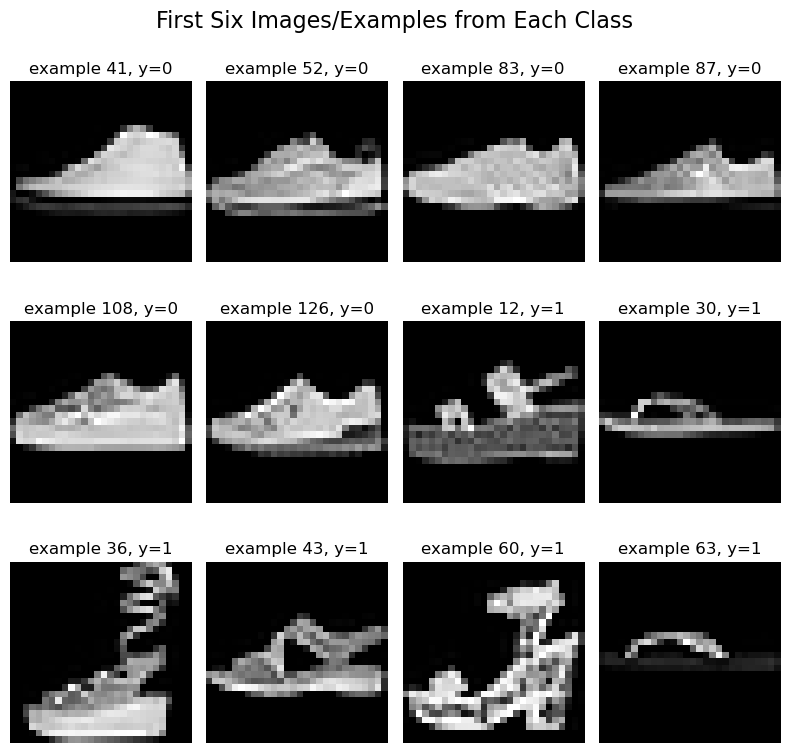

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# First six images/examples from each class
sneakers_idx = ss_train_labels[ss_train_labels['label'] == 0].index[:6]
sandals_idx = ss_train_labels[ss_train_labels['label'] == 1].index[:6]
sneakers_images = ss_train_set.loc[sneakers_idx].values.reshape(-1, 28, 28)
sandals_image = ss_train_set.loc[sandals_idx].values.reshape(-1, 28, 28)

# Combine the images into a single array
images = np.concatenate([sneakers_images, sandals_image])
indices = np.concatenate([sneakers_idx, sandals_idx])

# Plot the first six images/examples from each class
fig, axs = plt.subplots(3, 4, figsize=(8, 8))
plt.suptitle('First Six Images/Examples from Each Class', fontsize=16)
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"example {indices[i]}, y={ss_train_labels.loc[indices[i]]['label']}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Fitting your logistic regression classifier

In [157]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Split the training set into training and validation sets
training_data, validation_data = train_test_split(ss_train, test_size=0.2, random_state=5508)
training_y = training_data['label']
training_x = training_data.drop('label', axis=1)
validation_y = validation_data['label']
validation_x = validation_data.drop('label', axis=1)

number_iterations = 10000
learning_rate = 0.01
theta = np.random.randn(training_x.shape[1], 1)
m = len(training_data)
cost_history = []
vector_x = np.c_[np.ones((len(training_x), 1)), training_x]
new_y = np.reshape(training_y, (len(training_y), 1))
print(new_y.shape)
print(vector_x.shape)
print(sigmoid(vector_x.dot(theta)) - new_y.shape)

for i in range(number_iterations):
    # calculate the gradient vector using all instances
    est_p = 1 / (1 + np.exp(-np.dot(vector_x, theta)))
    gradients = 1/m * np.dot(vector_x.T, (est_p - training_y))
    # update the parameter vector
    theta -= learning_rate * gradients
    # compute the estimated probability for each instance
    est_p = 1 / (1 + np.exp(-np.dot(vector_x, theta)))
    # calculate the logistic regression cost function
    lr_cost = -1/m * np.sum(np.dot(new_y.T, np.log(est_p)) + np.dot((1-new_y).T, np.log(1-est_p)))
    cost_history.append(lr_cost)



(9590, 1)
(9590, 785)


ValueError: shapes (9590,785) and (784,1) not aligned: 785 (dim 1) != 784 (dim 0)

## Using cross-validation and Scikit-learn logistic regression classifier

## Analysing the performance closer

## Comparing models

## Exploring the ML pipeline